
Code produced on google colab environment




In [0]:
### Access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
## Import all packages needed

import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

Import train, validation arrays

In [0]:
X_train=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_train_200.npy')
y_train=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_train_200.npy')

In [0]:
X_train=X_train.reshape(6500,200,200,3)

In [0]:
X_val=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_val_200.npy')
y_val=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_val_200.npy')

In [0]:
X_val=X_val.reshape(1562,200,200,3)

In [0]:
## Load checkpoint and early stopping functions and other keras CNN modules

from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="/content/drive/My Drive/identify_pneumonia-master/model_1_weights/22.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop=EarlyStopping(monitor='val_loss', min_delta=0, verbose=0, mode='min', patience=10, restore_best_weights=False)

from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score


#Build CNN model 1
def create_model(X_train, y_train, X_val, y_val, params):

  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3), data_format='channels_last'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))    

  model.add(Flatten())        

##Define the hyperparameter configuration to Talos package

  model.add(Dense(params['dense1'], activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(params['dense2'], activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2 , activation='softmax'))

  from sklearn import metrics
  from keras import backend as K
  from tensorflow.keras.metrics import Recall
  from keras import optimizers

##Defined hyperparameters: loss function, otimizer, lr, decay, dense 1 units, dense 2 units, b size and dropout.

  categorical_loss='categorical_loss'
  
  if params['otimizer']==adam:
    model.compile(loss='categorical_crossentropy',
                    optimizer=params['otimizer'](lr=params['lr'], decay= params['decay'], beta_1=0.9, beta_2=0.999, amsgrad=False),
                    metrics=['acc'])
    
    print('yes')
  if params['otimizer']==sgd:
    model.compile(loss='categorical_crossentropy',

                    optimizer=params['otimizer'](lr=params['lr'], decay= params['decay'], momentum=0.9, nesterov=True),
                    metrics=['acc'])
    print('yes2x')


  history = model.fit(X_train, y_train,
                        batch_size=params['b_size'],
                        epochs=80,
                        validation_data=(X_val, y_val),
                        )
  tf.get_default_graph()

      # finally we have to make sure that history object and model are returned

  return history, model

In [0]:
!pip install talos

In [0]:
import talos

In [0]:
##Set the hyperparameter values

from keras import optimizers

sgd = optimizers.SGD
adam=optimizers.Adam

p = {'drop1':[0.6], 'drop2':[0.5], 'lr':[0.01,0.001], 'decay':[1e-6, 1e-4], 'dense1':[256,512], 'dense2':[128,256],
     'otimizer':[sgd,adam], 'b_size':[64,128], 'w1':[[0.25,4]]}

In [0]:
#start the scan by Talos (10% of total combinations: 6 experiments)

t = talos.Scan(x=X_train,
            y=y_train,
            model=create_model, 
            params=p,
            x_val=X_val, y_val=y_val,
            experiment_name='hyperoptimization_MODEL1_exp1',
            fraction_limit=0.05,
            random_method='quantum',
            print_params=True)





  0%|          | 0/6 [00:00<?, ?it/s]

{'b_size': 64, 'decay': 1e-06, 'dense1': 256, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.Adam'>, 'w1': [0.25, 4]}
yes
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 32s 5ms/step - loss: 0.4761 - acc: 0.8385 - val_loss: 0.4270 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4418 - acc: 0.8431 - val_loss: 0.4281 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4386 - acc: 0.8431 - val_loss: 0.4289 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4372 - acc: 0.8431 - val_loss: 0.4269 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4375 - acc: 0.8431 - val_loss: 0.4273 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4369 - acc: 0.843





 17%|█▋        | 1/6 [41:23<3:26:55, 2483.10s/it]

{'b_size': 128, 'decay': 0.0001, 'dense1': 512, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 33s 5ms/step - loss: 0.4750 - acc: 0.8358 - val_loss: 0.4280 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4377 - acc: 0.8431 - val_loss: 0.4264 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4369 - acc: 0.8431 - val_loss: 0.4275 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4345 - acc: 0.8431 - val_loss: 0.4242 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4332 - acc: 0.8431 - val_loss: 0.4206 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4283 - acc: 0.





 33%|███▎      | 2/6 [1:21:01<2:43:27, 2451.78s/it]

{'b_size': 64, 'decay': 1e-06, 'dense1': 256, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.Adam'>, 'w1': [0.25, 4]}
yes
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.4696 - acc: 0.8363 - val_loss: 0.4269 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4406 - acc: 0.8431 - val_loss: 0.4284 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4392 - acc: 0.8431 - val_loss: 0.4268 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4384 - acc: 0.8431 - val_loss: 0.4281 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4366 - acc: 0.8431 - val_loss: 0.4277 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4371 - acc: 0.843





 50%|█████     | 3/6 [2:01:13<2:01:59, 2439.79s/it]

{'b_size': 64, 'decay': 1e-06, 'dense1': 512, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.001, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 31s 5ms/step - loss: 0.5206 - acc: 0.8369 - val_loss: 0.4268 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4377 - acc: 0.8431 - val_loss: 0.4261 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4402 - acc: 0.8431 - val_loss: 0.4273 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4411 - acc: 0.8431 - val_loss: 0.4257 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4371 - acc: 0.8431 - val_loss: 0.4256 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4388 - acc: 0.8





 67%|██████▋   | 4/6 [2:41:24<1:21:02, 2431.00s/it]

{'b_size': 128, 'decay': 0.0001, 'dense1': 256, 'dense2': 256, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.001, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.6114 - acc: 0.8289 - val_loss: 0.5127 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4759 - acc: 0.8431 - val_loss: 0.4309 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4413 - acc: 0.8431 - val_loss: 0.4263 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4387 - acc: 0.8431 - val_loss: 0.4262 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4415 - acc: 0.8431 - val_loss: 0.4261 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4400 - acc: 0





 83%|████████▎ | 5/6 [3:20:39<40:08, 2408.34s/it]  

{'b_size': 128, 'decay': 1e-06, 'dense1': 256, 'dense2': 128, 'drop1': 0.6, 'drop2': 0.5, 'epochs': 75, 'lr': 0.01, 'otimizer': <class 'keras.optimizers.SGD'>, 'w1': [0.25, 4]}
yes2x
Train on 6500 samples, validate on 1562 samples
Epoch 1/80
6500/6500 [==============================] - 30s 5ms/step - loss: 0.4944 - acc: 0.8285 - val_loss: 0.4267 - val_acc: 0.8476
Epoch 2/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4376 - acc: 0.8431 - val_loss: 0.4266 - val_acc: 0.8476
Epoch 3/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4353 - acc: 0.8431 - val_loss: 0.4270 - val_acc: 0.8476
Epoch 4/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4363 - acc: 0.8431 - val_loss: 0.4270 - val_acc: 0.8476
Epoch 5/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4360 - acc: 0.8431 - val_loss: 0.4265 - val_acc: 0.8476
Epoch 6/80
6500/6500 [==============================] - 29s 5ms/step - loss: 0.4353 - acc: 0.8





100%|██████████| 6/6 [3:59:51<00:00, 2391.38s/it]





In [0]:
#Resume of experiments: training and validation accuracy/loss
# PS: experiment no. 4 were replaced by an individual experiment (option)

t.data

,round_epochs,val_loss,val_acc,loss,acc,b_size,decay,dense1,dense2,drop1,drop2,epochs,lr,otimizer,w1
0,80,0.426799,0.847631,0.434751,0.843077,64,0.000001,256,128,0.6,0.5,75,0.010,<class 'keras.optimizers.Adam'>,"[0.25, 4]"
1,80,0.339955,0.909731,0.070415,0.974769,128,0.000100,512,256,0.6,0.5,75,0.010,<class 'keras.optimizers.SGD'>,"[0.25, 4]"
2,80,0.426820,0.847631,0.435013,0.843077,64,0.000001,256,256,0.6,0.5,75,0.010,<class 'keras.optimizers.Adam'>,"[0.25, 4]"
3,80,0.255078,0.905250,0.251383,0.908000,64,0.000001,512,256,0.6,0.5,75,0.001,<class 'keras.optimizers.SGD'>,"[0.25, 4]"
4,80,0.315546,0.868758,0.336849,0.862615,128,0.000100,256,256,0.6,0.5,75,0.001,<class 'keras.optimizers.SGD'>,"[0.25, 4]"
5,80,0.319860,0.917414,0.081310,0.970923,128,0.000001,256,128,0.6,0.5,75,0.010,<class 'keras.optimizers.SGD'>,"[0.25, 4]"




```

```
CHOOSING THE BEST MODEL 1

--Define and replace the hyperparameters values for each of the 6 experiments(manually) and re-train each configuration.

--Save the best weights: for highest validation accuracy obtained before validation loss starts to increse.

In [0]:
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score

def pneumo_model():

  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3), data_format='channels_last'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))    

  model.add(Flatten())        


  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2 , activation='softmax'))

  from sklearn import metrics
  from keras import backend as K
  from tensorflow.keras.metrics import Recall
  from keras import optimizers

  categorical_loss='categorical_loss'
  model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=0.001 , decay=1e-6 , momentum=0.9, nesterov=True),
                  metrics=['acc'])

  history = model.fit(X_train, y_train,
                        batch_size=64,
                        epochs=150,
                        validation_data=(X_val, y_val), callbacks=[checkpoint, earlystop]
                        )

  

  return model, history

In [0]:
tf.get_default_graph()

MODEL 1 PERFORMANCE ON VALIDATION SET XP1'

--Load best model weights for each experiment

In [0]:
#load model1 with the replaced hyperparameters values (with each experiment configuration)
model_1=pneumo_model()

In [0]:
#only get the model architecture and parameters
bestmodel=model_1[0]

In [0]:
##load the saved weights of each experiment (IT IS IMPORTANT THAT "model_1" has the same configuration as the experiment in loading. Otherwise it will give errors in the weights)
bestmodel.load_weights('/content/drive/My Drive/identify_pneumonia-master/model_1_weights/3.1.hdf5')

In [0]:
#load the validation arrays and labels
X_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_val_200.npy')
y_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_val_200.npy')

In [0]:
X_test.shape

(5216, 3, 200, 200)

In [0]:
##reshape if there is an error on input shape
X_test=X_test.reshape(1562,200,200,3)

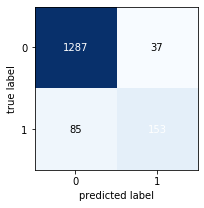

In [0]:
##Results on validation data

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
y_pred = bestmodel.predict(X_val)

thresholders=[]  
for x in range(len(y_pred)):
  if y_pred[x][1]>0.5:   #define threshold range (optional)
    thresholders.append(1)
  else:
    thresholders.append(0)

thr_pred=np.asarray(thresholders)

y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_val, axis=1)

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
plt.show()

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


FROM THE VALIDATION PREDICTION RESULTS ABOVE WE CHOOSE EXPERIMENT 1 AS BEST MODEL 1!!!

In [0]:
##Plot the model behavior
history=model_1[0]

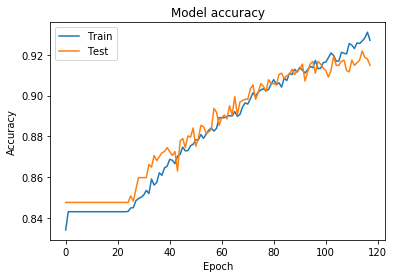

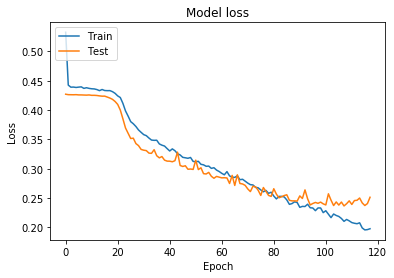

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Another performance metrics

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
 
fpr , tpr , thresholds = roc_curve (y_true, y_pred)

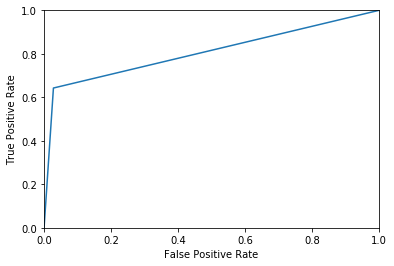

In [0]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

In [0]:
auc_score=roc_auc_score(y_true, y_pred)

In [0]:
auc_score

0.8074557617608977